# Implementing a deep CNN using PyTorch

## Loading and preprocessing the data

In [13]:
import torchvision
from torchvision import transforms

image_path = './'
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True, transform=transform, download=False
)

In [15]:
from torch.utils.data import Subset
import torch

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=False)

In [16]:
# construct the data loader with batches of 64 images for the training set and validation set, respectively

from torch.utils.data import DataLoader

batch_size=64
torch.manual_seed(1)

train_dl = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size=batch_size, shuffle=False)

## Constructing a CNN in PyTorch

In [17]:
import torch.nn as nn

model = nn.Sequential()
model.add_module(
    'conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
)
model.add_module(
    'relu1', nn.ReLU()
)
model.add_module(
    'pool1', nn.MaxPool2d(kernel_size=2)
)
model.add_module(
    'conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
)
model.add_module(
    'relu2', nn.ReLU()
)
model.add_module(
    'pool2', nn.MaxPool2d(kernel_size=2)
)
model.add_module(
    'flatten', nn.Flatten()
)

### to compute the output size of the model
# x = torch.ones((4, 1, 28, 28))
# model(x).shape
### 

model.add_module(
    'fc1', nn.Linear(3136, 1024) # after flattening the input, its size = 3136
)
model.add_module(
    'relu3', nn.ReLU()
)
model.add_module(
    'dropout', nn.Dropout(p=0.5)
)
model.add_module(
    'fc2', nn.Linear(1024, 10) 
)
# the softmax function is already used internally inside PyTorch’s CrossEntropyLoss implementation, 
# which is why don’t have to explicitly add it as a layer after the output layer above.

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch]+=is_correct.sum()
            
            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
            
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [20]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9493 val_accuracy: 0.9809
Epoch 2 accuracy: 0.9839 val_accuracy: 0.9875
Epoch 3 accuracy: 0.9892 val_accuracy: 0.9881
Epoch 4 accuracy: 0.9917 val_accuracy: 0.9871
Epoch 5 accuracy: 0.9933 val_accuracy: 0.9894
Epoch 6 accuracy: 0.9943 val_accuracy: 0.9905
Epoch 7 accuracy: 0.9952 val_accuracy: 0.9869
Epoch 8 accuracy: 0.9956 val_accuracy: 0.9912
Epoch 9 accuracy: 0.9965 val_accuracy: 0.9896
Epoch 10 accuracy: 0.9965 val_accuracy: 0.9876
Epoch 11 accuracy: 0.9970 val_accuracy: 0.9915
Epoch 12 accuracy: 0.9974 val_accuracy: 0.9884
Epoch 13 accuracy: 0.9980 val_accuracy: 0.9904
Epoch 14 accuracy: 0.9973 val_accuracy: 0.9881
Epoch 15 accuracy: 0.9977 val_accuracy: 0.9908
Epoch 16 accuracy: 0.9981 val_accuracy: 0.9906
Epoch 17 accuracy: 0.9976 val_accuracy: 0.9899
Epoch 18 accuracy: 0.9982 val_accuracy: 0.9903
Epoch 19 accuracy: 0.9982 val_accuracy: 0.9903
Epoch 20 accuracy: 0.9987 val_accuracy: 0.9929


Text(0, 0.5, 'Accuracy')

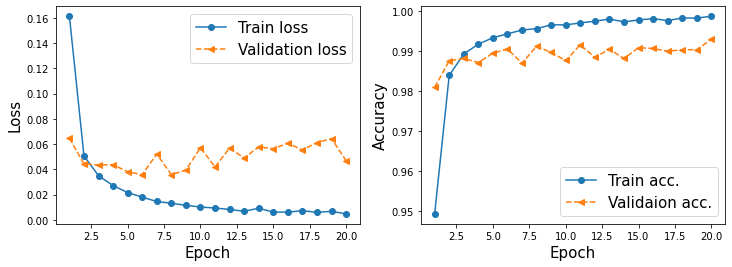

In [22]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax =  fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validaion acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

In [23]:
# evaluate the trained model on the test dataset

pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9939


`mnist_test_dataset[0]` is a tuple of (image matrix, label)

so, `mnist_test_dataset[0][0]` returns the image matrix -- a 3d tensor

`mnist_test_dataset[0][0][0, :, :]` returns the 2D image matrix

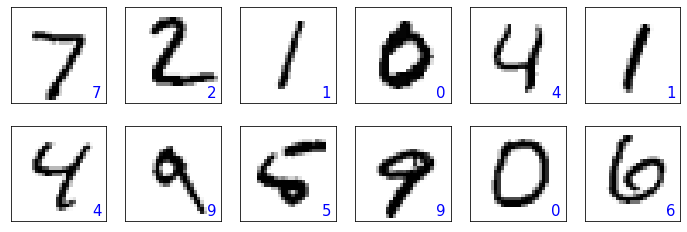

In [24]:
# get the prediction results in the form of class-membership probabilities and convert them to predicted labels
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :] 
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
plt.show()